In [1]:
from wavelet_texture_segmentation.feature_extractor import wavelet_texture_features_segmentation
from distance_regularized_level_set_evolution.find_lsf import find_lsf

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, grey_closing, grey_opening, grey_dilation, grey_erosion
from skimage import measure, metrics


In [2]:
def normalize(image):
    """Normalizes the image intensity values to the range [0, 1]."""
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) / (1 if image_max == image_min else abs(image_max - image_min))
    return normalized_image

def log_normalize(image):
    """Logarithmically normalizes the image intensity values to the range [0, 1]."""
    image = np.real(np.log(image + 1))
    return normalize(image)

def plot_features(features):
    for i in range(features.shape[3]):
        for j in range(features.shape[2]):
            plt.subplot(features.shape[3],features.shape[2],(i*features.shape[2])+j+1)
            plt.imshow(features[:,:,j,i])
    plt.show()

def create_gaussian_disk(radius, sigma):
    x = np.arange(-radius, radius + 1)
    y = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(x, y)
    # Calculate distances from the center
    distances = np.sqrt(xx**2 + yy**2)
    # Create disk mask
    disk = distances <= radius
    # Create Gaussian distribution
    gaussian = gaussian_filter(disk.astype(float), sigma=sigma)
    # Normalize the distribution
    gaussian /= np.sum(gaussian)
    return gaussian

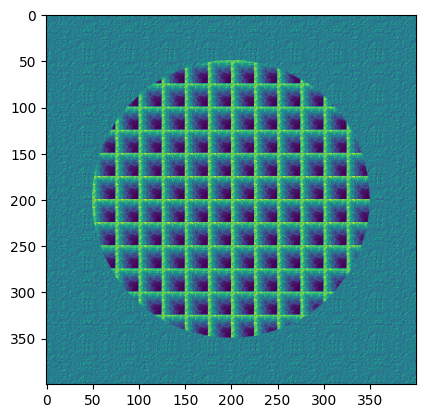

In [3]:
image_path = "samples/texture5.jpg"

image = cv2.imread(image_path)
# image = cv2.resize(image, (300,400))
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)

n = 27  # size of the sub-image blocks (better if even)
offset = (n - 1) // 2

image_size = gray_image.shape
plt.imshow(gray_image)
plt.show()

In [146]:
feature_methods = {"contrast", "cluster", "energy", "dissimilarity", "homogeneity", "ASM", "correlation"}
WCFs = wavelet_texture_features_segmentation(gray_image, n, feature_methods=feature_methods)

plot_features(WCFs)

<class 'int'> returned a result with an exception set


In [4]:
filename = f"data/WCFs_{image_path[image_path.rindex('/')+1:image_path.rindex('.')]}.npy"

# with open(filename, 'wb') as f:
#     np.save(f, WCFs)

with open(filename, 'rb') as f:
    WCFs = np.load(f)

In [5]:
smoothedWCFs = np.zeros_like(WCFs)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        # smoothedWCFs[:,:, i, j] = median_filter(invertedWCFs[:,:,i,j], n)
        smoothedWCFs[:,:, i, j] = gaussian_filter(WCFs[:,:,i,j], 1.5)
        # smoothedWCFs[:,:, i, j] = grey_opening(grey_closing(WCFs[:,:,i,j], 5), 5)

In [6]:
normalizedWCFs = np.zeros_like(WCFs)
for i in range(WCFs.shape[2]):
    normalizedWCFs[:,:, i, 0] = normalize(smoothedWCFs[:,:,i, 0])
    normalizedWCFs[:,:, i, 1] = log_normalize(smoothedWCFs[:,:,i, 1])
    normalizedWCFs[:,:, i, 2] = normalize(smoothedWCFs[:,:,i, 2])
    normalizedWCFs[:,:, i, 3] = normalize(smoothedWCFs[:,:,i, 3])
    normalizedWCFs[:,:, i, 4] = normalize(smoothedWCFs[:,:,i, 4])
    normalizedWCFs[:,:, i, 5] = normalize(smoothedWCFs[:,:,i, 5])
    normalizedWCFs[:,:, i, 6] = normalize(smoothedWCFs[:,:,i, 6])

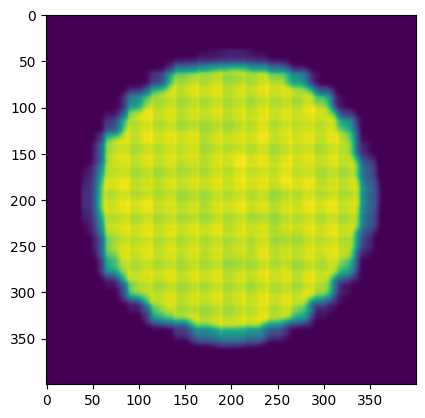

In [7]:
def invert(X):
    return (X - 1) * -1

invertedWCFs = normalizedWCFs.copy()

std_deviations = np.std(invertedWCFs, axis=(0, 1))

# y = np.argmax(np.max(std_deviations, axis=0))
# x = np.argmax(std_deviations, axis=0)[y]

i1 = std_deviations.flatten().argsort()[-1]

# MAYBE TAKE FEW HIGHEST DEVIATION WCFs AND CHOOSE SOME WHICH HAS MOST SIMILARITIES
highest_deviation = invertedWCFs[:,:,i1//WCFs.shape[3], i1%WCFs.shape[3]]

plt.imshow(highest_deviation)

for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        if metrics.mean_squared_error(highest_deviation, invertedWCFs[:,:,i,j]) > metrics.mean_squared_error(highest_deviation, invert(invertedWCFs[:,:,i,j])):
            invertedWCFs[:,:, i, j] = invert(invertedWCFs[:,:,i, j])
    
    # for j in range(WCFs.shape[3]):
    #     x = np.mean(normalizedWCFs[:,:,i,j])
    #     y = np.mean(normalizedWCFs[:,:,0,0][phi<0])
    #     if x > y:
    #         invertedWCFs[:,:,i,j] = (normalizedWCFs[:,:,i,j] - 1) * -1
    #     else:
    #         invertedWCFs[:,:,i,j] = normalizedWCFs[:,:,i,j]

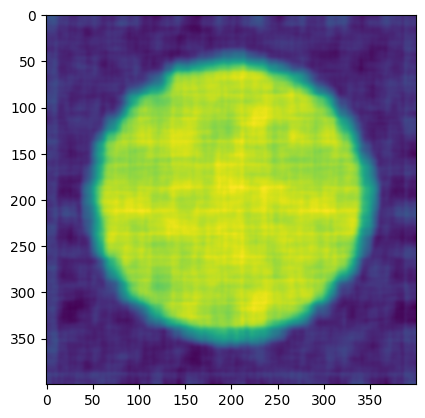

In [8]:
combinedWCFs = np.mean(np.mean(invertedWCFs, 3), 2)
# combinedWCFs = gmean(gmean(smoothedWCFs, 3), 2)
# combinedWCFs = hmean(hmean(smoothedWCFs + 0.000000001, 3), 2)

combinedWCFs = normalize(combinedWCFs)

plt.imshow(combinedWCFs)
plt.show()

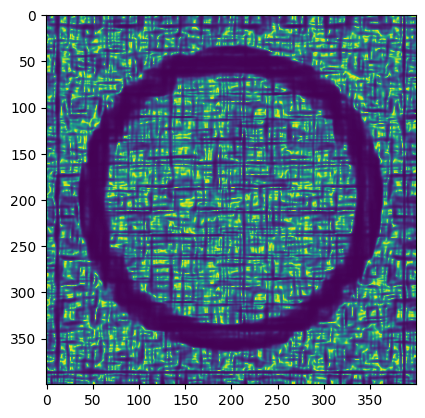

In [9]:
[Iy, Ix] = np.gradient(combinedWCFs * 256)
f = np.square(Ix) + np.square(Iy)
g_texture = 1 / (1 + f)

# gray_smooth = gaussian_filter(gray_image, 0.8)
# [Iy, Ix] = np.gradient(gray_smooth)
# f = np.square(Ix) + np.square(Iy)
# g2 = 1 / (1 + f)  # edge indicator function.
# plt.imshow(g2)
# plt.show()

plt.imshow(g_texture)
plt.show()

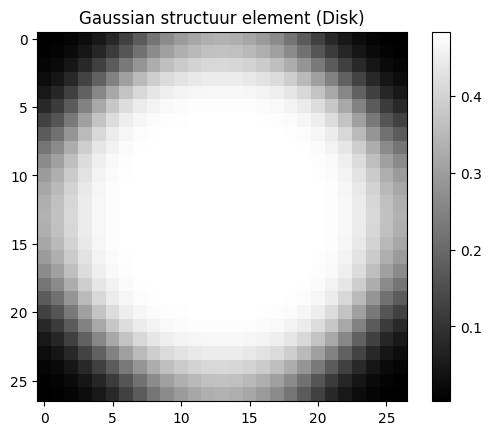

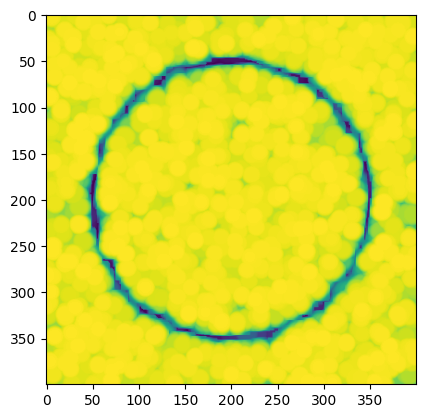

In [10]:
radius = int(n/2)
sigma = 2
structuring_element = create_gaussian_disk(radius, sigma) * 256

# Visualize the structured element
plt.imshow(structuring_element, cmap='gray', interpolation='nearest')
plt.title('Gaussian structuur element (Disk)')
plt.colorbar()
plt.show()

g_texture_modified = grey_dilation(g_texture, structure=structuring_element)

plt.imshow(g_texture_modified)
plt.show()

In [26]:
cv2.imwrite("texture5_dilation_texture_edges.jpg", g_texture_modified*255)

True

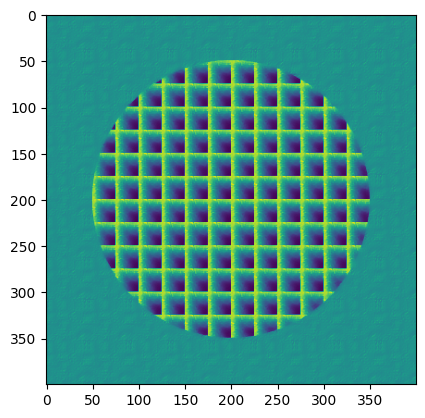

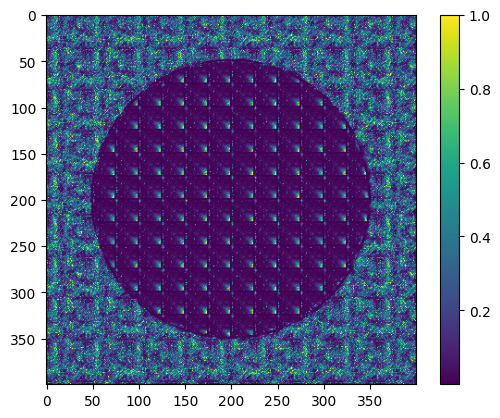

In [56]:
edge_preserving_blur = cv2.bilateralFilter(image, 9, 75, 75)
gray_smooth = cv2.cvtColor(edge_preserving_blur, cv2.COLOR_BGR2GRAY).astype(np.uint8)
# gray_smooth = cv2.medianBlur(gray_image, n)

plt.imshow(gray_smooth)
plt.figure()

[Iy, Ix] = np.gradient(gray_smooth)
f = np.square(Ix) + np.square(Iy)

# Remove small edges
# How to find threshold ??
# f[f < 100] = 0

g_edge = 1 / (1 + f)  # edge indicator function.

plt.imshow(g_edge)
plt.colorbar()
plt.show()

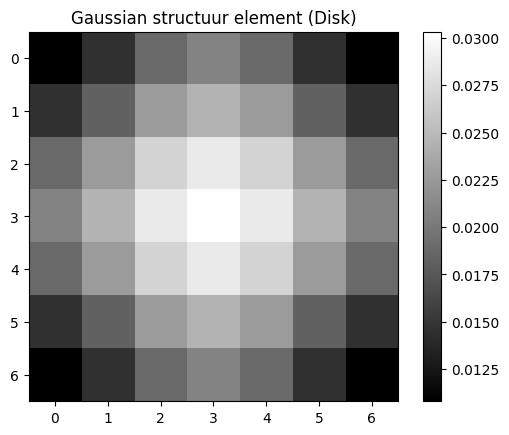

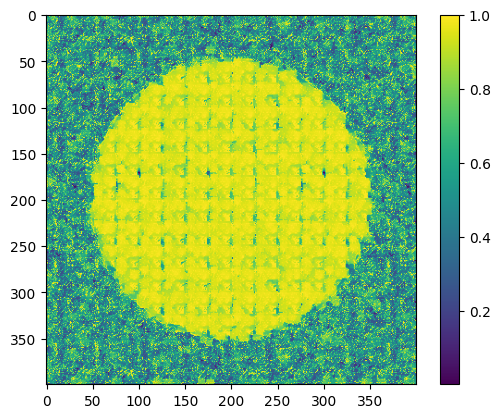

In [57]:
radius = 3
sigma = 1.5
structuring_element = create_gaussian_disk(radius, sigma)

# Visualize the structured element
plt.imshow(structuring_element, cmap='gray', interpolation='nearest')
plt.title('Gaussian structuur element (Disk)')
plt.colorbar()
plt.show()

g_edge_modified = g_edge + invert(grey_closing(g_edge, structure=structuring_element)) # Remove edges in areas where lots of edges are compacted together (texture areas)

plt.imshow(g_edge_modified)
plt.colorbar()
plt.show()

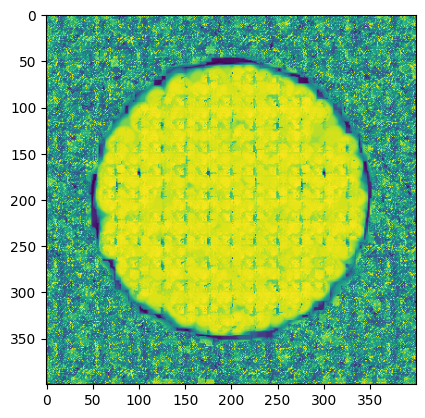

In [59]:
g_combined = np.minimum(normalize(g_edge_modified), normalize(g_texture_modified))

plt.imshow(g_combined)
plt.show()

In [60]:
c0 = 2
initial_lsf = c0 * np.ones(image_size)
initial_lsf[10:-10, 10:-10] = -c0

In [61]:
iteration = 0
phi = initial_lsf.copy()
last_title = ""
cv2.imshow(last_title, image)

while True:
    phi = find_lsf(
        g=g_combined, # g_modified * (g_modified > tresh)
        initial_lsf=phi,
        timestep=5,
        iter_inner=20,
        iter_outer=1,
        lmda=50,
        alfa=2,
        epsilon=1.5)
    iteration += 1
    
    contours = measure.find_contours(phi, 0)

    contour_image = image.copy()
    cv_contours = []
    for contour in contours:
        cv_contour = np.array([[int(point[1]), int(point[0])] for point in contour], dtype=np.int32)
        cv_contours.append(cv_contour)
    cv2.drawContours(contour_image, cv_contours, -1, (0, 0, 255), 2)

    if not cv2.getWindowProperty(last_title, cv2.WND_PROP_VISIBLE): break # Stop when window was closed

    cv2.imshow(last_title, contour_image)

    new_title = f"DRLSE iteration {iteration}"
    cv2.setWindowTitle(last_title, new_title)
    last_tile = new_title

    if cv2.waitKey(1) != -1: break # Stop when key was pressed
cv2.destroyAllWindows()

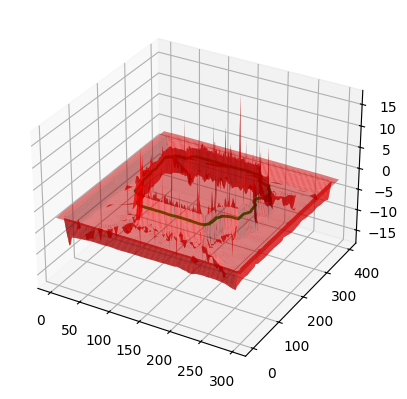

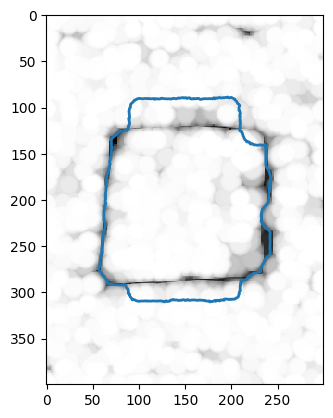

In [55]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi, 0)

ax2 = fig2.add_subplot(111)
ax2.imshow(g_modified, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)